In [1]:
import os
import os.path
import cv2
import numpy as np
from datetime import datetime
from collections import OrderedDict
import hdf5storage
from scipy import ndimage
import torch
from utils import utils_deblur
from utils import utils_logger
from utils import utils_model
from utils import utils_pnp as pnp
from utils import utils_sisr as sr
from utils import utils_image as util

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
# mdname = 'drunet_gray.pth'
mdname = 'dncnn_25.pth'
mdpath = os.path.join('model_zoo', mdname)
# imname = 'parrots.png'
imname = 'bird_GT.bmp'
# set12  Set3C
noise_level = 0.01
border = 0
n_channels=1
nb = 17
iter_num = 8
modelSigma1 = 49
modelSigma2 = noise_level * 255.

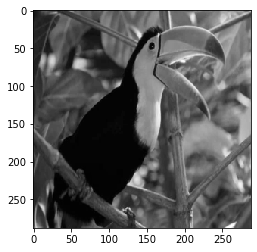

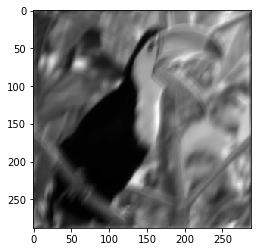

In [6]:
impath = os.path.join('/home2/liuqi/wsmat/DAEP-master/Set5', imname)
model_path = os.path.join('model_zoo', mdname)
kernels = hdf5storage.loadmat(os.path.join('kernels', 'Levin09.mat'))['kernels']

k = kernels[0, 1].astype(np.float64)
# util.imshow(k)
img_H = cv2.imread(impath, cv2.IMREAD_UNCHANGED)
if img_H.ndim == 3:
    img_Hycbcr = util.bgr2ycbcr(img_H, False)
    img_H = img_Hycbcr[...,0]
    img_H1 = img_H
img_H = np.expand_dims(img_H, axis=2)  # HxWx1
img_H = util.modcrop(img_H, 8)
img_L = ndimage.filters.convolve(img_H, np.expand_dims(k, axis=2), mode='wrap')
util.imshow(img_H)
util.imshow(img_L)
img_L = util.uint2single(img_L)
np.random.seed(seed=0)  # for reproducibility
img_L += np.random.normal(0, noise_level, img_L.shape) # add AWGN

DRUNet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
from models.network_unet import UNetRes as net
model = net(in_nc=n_channels + 1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R',
            downsample_mode="strideconv", upsample_mode="convtranspose")
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
for _, v in model.named_parameters():
    v.requires_grad = False
model = model.to(device)

DnCNN

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
from models.network_dncnn import DnCNN as net
model = net(in_nc=n_channels, out_nc=n_channels, nc=64, nb=nb, act_mode='R')
model.load_state_dict(torch.load(mdpath), strict=True)
model.eval()
for k, v in model.named_parameters():
    v.requires_grad = False
model = model.to(device)
number_parameters = sum(map(lambda x: x.numel(), model.parameters()))
print('Params number: {}'.format(number_parameters))

Params number: 555137


Prepare parameters and FFT components

In [7]:
iter_num = 10
rhos, sigmas = pnp.get_rho_sigma( noise_level, iter_num, modelSigma1,modelSigma2, 1.0)
rhos, sigmas = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device)
xinit = util.single2tensor4(img_L).to(device)
img_L_tensor, k_tensor = util.single2tensor4(img_L), util.single2tensor4(np.expand_dims(k, 2))
[k_tensor, img_L_tensor] = util.todevice([k_tensor, img_L_tensor], device)
FB, FBC, F2B, FBFy = sr.pre_calculate(img_L_tensor, k_tensor, 1)

HQS method iteration

In [12]:
x = xinit
for i in range(iter_num):
    tau = rhos[i].float()
    tau = tau.repeat(1, 1, 1, 1)
    x = sr.data_solution(x, FB, FBC, F2B, FBFy, tau, 1)
    xpre = x
    x = model(x)
    img_H1 = img_H.squeeze()
    img_xiter = util.tensor2uint(xpre)
    psnr = util.calculate_psnr(img_xiter, img_H1, border=border)
    print('iter {:d}   psnr{:.4f}'.format(i,psnr))

iter 0   psnr20.1687
iter 1   psnr21.3310
iter 2   psnr22.8425
iter 3   psnr24.6180
iter 4   psnr26.7023
iter 5   psnr29.0383
iter 6   psnr31.2319
iter 7   psnr32.4352
iter 8   psnr32.2449
iter 9   psnr31.2789


SB method iteration

In [23]:
r_weight = 0.48
varr = xinit
vard = torch.zeros_like(xinit)
varb = torch.zeros_like(xinit)
print('begin iter')
for i in range(iter_num):
#     print('iter {:d}'.format(i))
#     tau = rhos[i].repeat(1, 1, 1, 1)
    tau = rhos[i].float()
    tau = tau.repeat(1, 1, 1, 1)
    xtilde = varr-vard+varb
    xpre = sr.data_solution(xtilde, FB, FBC, F2B, FBFy, tau, 1)
    varr = model(xpre)
    vard = r_weight*(varr - xpre + varb)
    varb += varr - xpre - vard
    img_xiter = util.tensor2uint(xpre)
    psnr = util.calculate_psnr(img_xiter, img_H1, border=border)
    print('iter {:d}   psnr{:.4f}'.format(i,psnr))

begin iter
iter 0   psnr20.1687
iter 1   psnr21.4329
iter 2   psnr23.0484
iter 3   psnr24.9293
iter 4   psnr27.1221
iter 5   psnr29.5423
iter 6   psnr31.6762
iter 7   psnr32.5754
iter 8   psnr32.0885
iter 9   psnr30.9937
